## <center>Методи та технології аналітики даних</center>
## <center>Лабораторна робота №4</center>
#### <center>ФБ-25 Кравченко Максим</center>

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [87]:
file_name = r'..\Dataset\adult_cleaned.data'
headers = ['Age', 'Work_class', 'Final_weight', 'Education', 'Education_num', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_gain', 'Capital_loss', 
           'Hours_per_week', 'Native_country', 'Income']
df = pd.read_csv(file_name, sep=",", header=1, names=headers, na_values='?')
df

,Age,Work_class,Final_weight,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
2,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
3,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
4,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30154,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
30155,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
30156,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
30157,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Отримуємо кластери з минулої лаб. роботи

In [88]:
columns_to_use = ['Age', 'Hours_per_week']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[columns_to_use])

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

cluster_centers = kmeans.cluster_centers_

df['Cluster'] = kmeans.labels_

cluster_counts = df['Cluster'].value_counts().sort_index()

centers_and_counts = pd.DataFrame(cluster_centers, columns=columns_to_use)
centers_and_counts['Cluster_size'] = cluster_counts.values

centers_and_counts

,Age,Hours_per_week,Cluster_size
0,1.124798,-0.156438,9450
1,-1.047697,-1.688356,3114
2,0.164043,1.903226,3128
3,-0.544583,0.054073,14467


In [89]:
top_clusters = centers_and_counts.nlargest(2, 'Cluster_size').index
df_top_clusters = df[df['Cluster'].isin(top_clusters)].copy()

df_top_clusters['Two_Cluster'] = df_top_clusters['Cluster'].apply(lambda x: 'cluster_0' if x == top_clusters[0] else 'cluster_1')

x_train, x_test, y_train, y_test = train_test_split(
    df_top_clusters[columns_to_use], df_top_clusters['Two_Cluster'], test_size=0.4, random_state=42
)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)
table_data = classification_report(y_test, y_pred, output_dict=True)

table = pd.DataFrame(table_data).transpose()

table

,precision,recall,f1-score,support
cluster_0,1.0,1.0,1.0,5852.0
cluster_1,1.0,1.0,1.0,3715.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,9567.0
weighted avg,1.0,1.0,1.0,9567.0


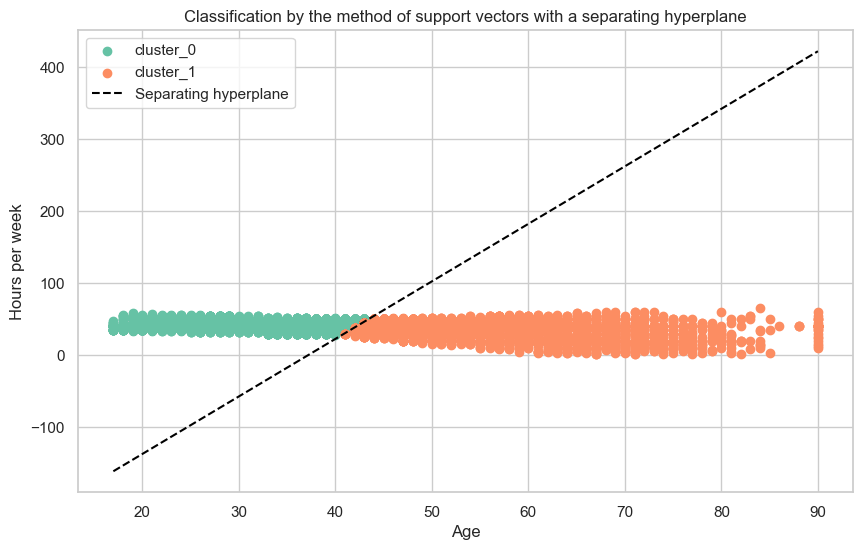

In [90]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))

pallette = sns.color_palette("Set2")

for cluster, color in zip(['cluster_0', 'cluster_1'], pallette):
    plt.scatter(
        df_top_clusters[df_top_clusters['Two_Cluster'] == cluster]['Age'],
        df_top_clusters[df_top_clusters['Two_Cluster'] == cluster]['Hours_per_week'],
        label=f'{cluster}',
        color=color
    )

w = svm_model.coef_[0]
b = svm_model.intercept_[0]

x_values = np.linspace(df_top_clusters['Age'].min(), df_top_clusters['Age'].max(), 100)
y_values = -(w[0] * x_values + b) / w[1]

plt.plot(x_values, y_values, color='black', linestyle='--', label='Separating hyperplane')

plt.xlabel('Age')
plt.ylabel('Hours per week')
plt.legend()
plt.title('Classification by the method of support vectors with a separating hyperplane')
plt.show()

In [91]:
slope = -w[0] / w[1]
intercept = -b / w[1]
print(f'Equation separating hyperplane: y = {slope:.2f}x + {intercept:.2f}')

Equation separating hyperplane: y = 8.00x + -297.50
